# Linear Model Testing & Evaluation

In [32]:
# Dependencies
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import math
import seaborn as sns
import pickle

In [12]:
os.getcwd()

'/Users/Joris/Documents/Studie/Information Studies/FDS/Assignment 2/Lin_Model_Joris'

In [42]:
# Location files
features_loc = "../dataset/time_scored/train_feat_cleaned.pickle"
target_loc = "../dataset/time_scored/train_target_cleaned.pickle"

In [43]:
features_df = pd.read_pickle(features_loc)
target_df = pd.read_pickle(target_loc)

In [15]:
target_df[target_df["PERMA"].isna()]

,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,...,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account


In [16]:
target_df.columns

Index(['id', 'gender', 'born', 'education', 'employed', 'income', 'A_2', 'N_1',
       'P_1', 'E_1', 'A_1', 'H_1', 'M_1', 'R_1', 'M_2', 'E_2', 'LON', 'H_2',
       'P_2', 'N_2', 'A_3', 'N_3', 'E_3', 'H_3', 'R_2', 'M_3', 'R_3', 'P_3',
       'HAP', 'participate', 'insta_user_id', 'completed', 'start_q', 'end_q',
       'network_id', 'P', 'E', 'R', 'M', 'A', 'PERMA', 'N_EMO', 'P_EMO',
       'imagecount', 'private_account'],
      dtype='object')

In [17]:
# Create vector for columns of questions
questions = list(target_df.columns[6:29])
questions.remove('LON')
questions = [q for q in questions if q not in ('LON', 'N_1', 'N_2', 'N_3','H_1', 'H_2', 'H_3')]
questions.sort()
print(questions)

['A_1', 'A_2', 'A_3', 'E_1', 'E_2', 'E_3', 'HAP', 'M_1', 'M_2', 'M_3', 'P_1', 'P_2', 'P_3', 'R_1', 'R_2', 'R_3']


In [18]:
# Check if all individual questions aa up to the PERMA score
(target_df[questions].mean(axis = 1) == target_df["PERMA"]).mean()

1.0

In [19]:
# Check missing values
print(features_df.isnull().sum().sum(), 
      target_df.isnull().sum().sum())

0 0


In [20]:
# Basic linear model with all features

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df["PERMA"], test_size = 0.20, random_state=10)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: -7.12633605570154
Root Mean Squared Error: 4.33079276809014


Full model gets a negative r^2, so reaaly bad.

In [21]:
# Try a number of times using Cross validation
# Not for report

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, features_df, target_df["PERMA"], cv = 5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


[-3.89935329e-01 -1.13319438e-01 -3.35003899e-01 -7.92201249e-01
 -2.00393283e+02]
Average 5-Fold CV Score: -40.40474850592336


In [22]:
# Trying a Lasso Regression
X = features_df
y = target_df["PERMA"]

a_space = np.linspace(0.01, 1, 100)
param_grid = {'alpha': a_space}
# Instantiate a lasso regressor: lasso
lasso = Lasso()

# Instantiate the GridSearchCV object: logreg_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=10)

# Fit the regressor to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(lasso_cv.best_params_)) 
print("Best score is {}".format(lasso_cv.best_score_))


Tuned Logistic Regression Parameters: {'alpha': 0.06999999999999999}
Best score is -0.03828511360479989


/Users/Joris/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
# Use MLXtend package to automaticly do forward feature selection

X = features_df
y = target_df["PERMA"]

lr = LinearRegression()

sfs = SFS(lr, 
          k_features="best", 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=10)

sfs = sfs.fit(X, y)

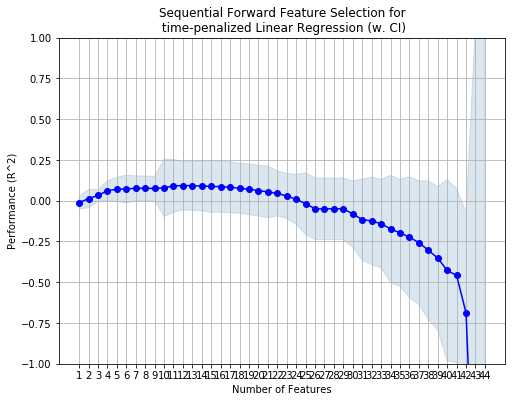

In [60]:
fig = plot_sfs(sfs.get_metric_dict(), kind='ci', figsize= (8,6))

plt.ylim(-1,1)
plt.title('Sequential Forward Feature Selection for\n time-penalized Linear Regression (w. CI)')
plt.ylabel("Performance (R^2)")
plt.grid()
# plt.show()
plt.savefig("../images/LR_Forward_Selection-time.png")

In [25]:
best_feat = list(sfs.k_feature_names_)
print("Amount chosen", len(sfs.k_feature_idx_),
    "CV score:", sfs.k_score_,
      
    "Best features:", *best_feat, sep = "\n")
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

Amount chosen
13
CV score:
0.16473305317010006
Best features:
user_posted_photos
face_emotion_CALM
face_emotion_CONFUSED
facial_hear
unkown_gender
male
anp_sentiment
emotion_label_annoyance
emotion_label_disgust
emotion_label_pensiveness
emotion_label_rage
emotion_label_sadness
emotion_label_terror


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(36,)","[0.04184606879753061, 0.03301993718397411, -0....",-0.0188204,"(emotion_label_rage,)",0.0699055,0.0941219,0.031374
2,"(36, 37)","[0.08465552488387929, -0.03004561690683083, 0....",0.000567345,"(emotion_label_rage, emotion_label_sadness)",0.121839,0.164046,0.054682
3,"(3, 36, 37)","[0.19612938048999573, -0.24936370658007911, 0....",0.0486808,"(user_posted_photos, emotion_label_rage, emoti...",0.189907,0.255694,0.0852313
4,"(3, 17, 36, 37)","[0.26479397904539814, -0.1004901124927351, -0....",0.0653889,"(user_posted_photos, anp_sentiment, emotion_la...",0.158264,0.213089,0.0710296
5,"(3, 7, 17, 36, 37)","[0.2706173136008304, 0.051614529213692806, -0....",0.0796236,"(user_posted_photos, face_emotion_CALM, anp_se...",0.148918,0.200505,0.066835
6,"(3, 7, 15, 17, 36, 37)","[0.330488174245244, 0.3786256275395854, 0.0314...",0.129288,"(user_posted_photos, face_emotion_CALM, male, ...",0.165062,0.222242,0.0740808
7,"(3, 7, 15, 17, 36, 37, 40)","[0.29719067091817075, 0.43726766679592244, 0.0...",0.152266,"(user_posted_photos, face_emotion_CALM, male, ...",0.160367,0.215921,0.0719736
8,"(3, 7, 8, 15, 17, 36, 37, 40)","[0.3386066560609815, 0.5767776444095468, 0.085...",0.159294,"(user_posted_photos, face_emotion_CALM, face_e...",0.1774,0.238855,0.0796182
9,"(3, 7, 8, 15, 17, 27, 36, 37, 40)","[0.3387024384863079, 0.579555855962528, 0.0934...",0.160579,"(user_posted_photos, face_emotion_CALM, face_e...",0.17807,0.239756,0.0799186
10,"(3, 7, 8, 15, 17, 23, 27, 36, 37, 40)","[0.31847420610775057, 0.5794790253308744, 0.09...",0.160734,"(user_posted_photos, face_emotion_CALM, face_e...",0.177642,0.23918,0.0797266


In [26]:
# Evaluate best single model

# Create training and test sets
X_train_best, X_test_best, y_train, y_test = train_test_split(features_df[best_feat], target_df["PERMA"]
                                                    , test_size = 0.30, random_state=42)

# Create the regressor: reg_all
reg_best = LinearRegression()

# Fit the regressor to the training data
reg_best.fit(X_train_best, y_train)

# Predict on the test data: y_pred
y_pred = reg_best.predict(X_test_best)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_best.score(X_test_best, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.25939160709547093
Root Mean Squared Error: 1.112506712345294


In [27]:
# Create compound model of 6 perma score elements
perma_elements = ["P", "E", "R", "M", "A", "HAP"]

best_features = dict()

for question in perma_elements:
    lr = LinearRegression()
    sfs = SFS(lr, 
              k_features="best", 
              forward=True, 
              floating=False, 
              scoring='r2',
              cv=10)
    sfs = sfs.fit(features_df, target_df[question])
    best_features[question] = (sfs.k_score_, sfs.k_feature_names_)

In [28]:
list(best_features["P"][1])

['image_width',
 'user_posted_photos',
 'face_emotion_CONFUSED',
 'face_emotion_SURPRISED',
 'emotion_label_acceptance',
 'emotion_label_anger',
 'emotion_label_disgust',
 'emotion_label_ecstasy',
 'emotion_label_grief',
 'emotion_label_joy',
 'emotion_label_rage',
 'emotion_label_terror',
 'emotion_label_trust',
 'elapsed_time']

In [48]:
# Evaluate compound model

# Create training and test sets
X_train_flex, X_test_flex, y_train_flex, y_test_flex = train_test_split(features_df, target_df
                                                    , test_size = 0.30, random_state=69)
predicted_data = pd.DataFrame()
models = dict()

for element in perma_elements:
    # Create the regressor: lr
    lr = LinearRegression()

    # Extract the best features for the element
    features = list(best_features[element][1])
    
    # Fit the regressor to the training data
    lr.fit(X_train_flex[features], y_train_flex[element])

    # Predict on the test data: y_pred
    y_pred = lr.predict(X_test_flex[features])
  
    predicted_data[element] = y_pred
    models[element] = lr
    
predicted_data["PERMA"] = predicted_data.mean(1)


# Compute and print R^2 and RMSE
print("R^2: {}".format(r2_score(y_test_flex["PERMA"], predicted_data["PERMA"].values)))
rmse = np.sqrt(mean_squared_error(y_test_flex["PERMA"], predicted_data["PERMA"].values))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.23509279366103242
Root Mean Squared Error: 1.3615318619391297


In [44]:
# Save total model to pickle
pickle.dump(reg_all, open("../models/reg_all-time.pickle", 'wb'))
# Save best single model to pickle
pickle.dump(best_feat, open("../models/best_feat-time.pickle", 'wb'))
pickle.dump(reg_best, open("../models/reg_best-time.pickle", 'wb'))
# Save compound model to pickle
pickle.dump(best_features, open("../models/comp_features-time.pickle", 'wb'))
pickle.dump(models, open("../models/perma_el-time.pickle", 'wb'))
pickle.dump(perma_elements, open("../models/compound-time.pickle", 'wb'))

#### Dataset size & random seed discussion
Due to small size of the dataset and thus a small test dataset the RMSE & R^2 are heavily dependent on the random seed. Different seed choices result in large variations of the two statistics mentioned. To-Do: plot difference in statistic values per random_state in say...two or three regressors, 10 or 15 random_state values.

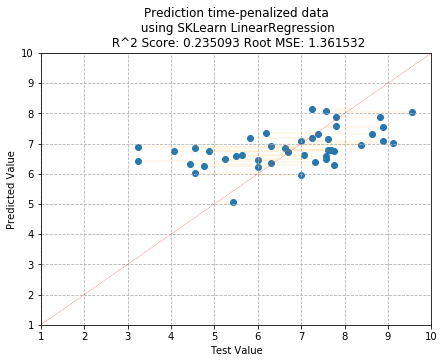

In [49]:
fig = plt.figure(figsize=(7,5))
xl = plt.xlim(1, 10)
yl = plt.ylim(1, 10)

ax = plt.gca()
ax.set_xlabel('Test Value')
ax.set_ylabel('Predicted Value')
plt.title('Prediction time-penalized data\n using SKLearn LinearRegression\n R^2 Score: %f Root MSE: %f'\
% (r2_score(y_test_flex["PERMA"], predicted_data["PERMA"].values),\
np.sqrt(mean_squared_error(y_test_flex["PERMA"], predicted_data["PERMA"].values))))

plt.scatter(x=y_test_flex["PERMA"], y=predicted_data["PERMA"])
plt.plot(xl, yl, '--', color='r',linewidth=0.3)
ax.hlines(y=predicted_data["PERMA"], xmin=predicted_data["PERMA"], xmax=y_test_flex["PERMA"], color='orange', linestyle='dotted', linewidth=0.4)
plt.grid(linestyle='--')
plt.savefig('../images/regression/SKL_LR_fig1-time.png', format='png')
plt.show()


In [19]:
print(y_test_flex["PERMA"].max() - predicted_data["PERMA"].max())
print(y_test_flex["PERMA"].min() - predicted_data["PERMA"].min())

for foo in zip(y_test_flex["PERMA"], predicted_data["PERMA"]):
    print(foo[0] - foo[1])




0.9430422020504654
-2.6321462664357567
0.7275060661335226
0.6942604647806832
-0.5584882999980323
0.9715783607023658
2.0168923399217524
1.470528758294968
1.1178537335642433
-1.016150086980967
0.912155568206356
-0.1050045407558855
0.07887375495987925
0.8471628834485427
-0.879870095271535
-1.5569577979495346
0.35540906229841074
-0.2405015049558985
0.2915173218824867
0.7215825305571855
2.3903539343805447
0.1340223381905732
0.5717226730073186
-1.0723157092539068
0.9149579893072186
-0.9272635766110815
0.07906217846684171
-2.4513683685017247
0.06506337884619029
-1.9948139750232246
0.6183845098116185
0.8638729883308249
1.154693739457528
1.1368859656993875
0.5503364004588853
-1.0481654599114174
0.2550854326790466
-1.699092100785463
-1.407908260383639
1.1519045008092883
1.4214415236111089
-1.2809746791529575
-0.3531502650327356
-3.028718297074512
0.558016544042971
-1.2285151971363248


#### Testing with an SVM

Some notes: the SVM benifits from as much training data as it can get. I gave it 90% to eat.
In testing for the target of the highest possible R^2 combined with the lowest possible MSE, I iterated over a range of C=0.7-1.3 and e=0.0-0.3 where C is the penalty for falling outside the epsilon tube and e is the radius of the tube.

In [56]:
# Evaluate compound model with an SVM

# Create training and test sets
X_train_flex, X_test_flex, y_train_flex, y_test_flex = train_test_split(features_df, target_df
                                                    , test_size = 0.10, random_state=69)
predicted_data = pd.DataFrame()
models_svm = dict()

for element in perma_elements:
    # Create the regressor: SVR
    clf = SVR(kernel='linear', gamma='scale', C=1.3, epsilon=0)

    # Extract the best features for the element
    features = list(best_features[element][1])
    
    # Fit the regressor to the training data
    clf.fit(X_train_flex[features], y_train_flex[element])

    # Predict on the test data: y_pred
    y_pred = clf.predict(X_test_flex[features])
    
    models_svm[element] = clf
  
    predicted_data[element] = y_pred
    
predicted_data["PERMA"] = predicted_data.mean(1)

# Compute and print R^2 and RMSE
print("R^2: {}".format(r2_score(y_test_flex["PERMA"], predicted_data["PERMA"].values)))
rmse = np.sqrt(mean_squared_error(y_test_flex["PERMA"], predicted_data["PERMA"].values))
print("Root Mean Squared Error: {}".format(rmse))

R^2: -0.17937408198932303
Root Mean Squared Error: 1.5552300891836104


In [57]:
# Save compound model to pickle
pickle.dump(models_svm, open("../models/models_svm-time.pickle", 'wb'))

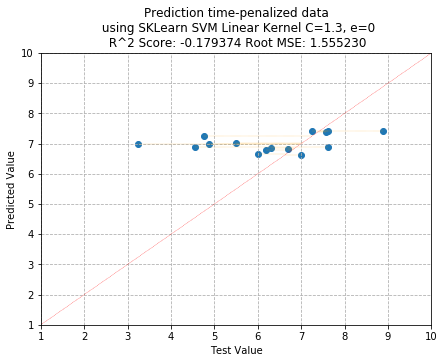

In [52]:
fig = plt.figure(figsize=(7,5))
xl = plt.xlim(1, 10)
yl = plt.ylim(1, 10)

ax = plt.gca()
ax.set_xlabel('Test Value')
ax.set_ylabel('Predicted Value')
plt.title('Prediction time-penalized data\n using SKLearn SVM Linear Kernel C=1.3, e=0\n \
R^2 Score: %f Root MSE: %f' % (r2_score(y_test_flex["PERMA"],\
predicted_data["PERMA"].values), np.sqrt(mean_squared_error(y_test_flex["PERMA"], \
predicted_data["PERMA"].values))))

ax.scatter(x=y_test_flex["PERMA"], y=predicted_data["PERMA"])
ax.plot(xl, yl, '--', color='r',linewidth=0.3)
ax.hlines(y=predicted_data["PERMA"], xmin=predicted_data["PERMA"], xmax=y_test_flex["PERMA"], color='orange', linestyle='dotted', linewidth=0.4)
ax.grid(linestyle='--')
plt.savefig('../images/regression/SKL_SVM_LK_fig1-time.png', format='png')
plt.show()


# Old stuff, ignore for now

In [22]:
# # Scale data
# scaler = preprocessing.StandardScaler()
# features_df_scaled = features_df.copy()
# features_df_scaled[features_df_scaled.columns] = scaler.fit_transform(
#     features_df_scaled[features_df_scaled.columns])

# normalizer = preprocessing.Normalizer()
# features_df_norm = features_df.copy()
# features_df_norm[features_df_norm.columns] = scaler.fit_transform(
#     features_df_norm[features_df_norm.columns])

# features_df_n=((features_df-features_df.min())/(features_df.max()-features_df.min()))

# plt.plot(features_df_n.std())
# Check variance
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# sel.fit_transform(X)
features_df.shape

(144, 43)

In [23]:
# the intercept is the expected mean of the perma score if some X is equal to 0
# in our case, it's pretty low
print('Estimated intercept coefficient:', lr.intercept_)

# the number of coefficients
print('Number of coefficients:', len(lr.coef_))

# output the coefficients
pd.DataFrame(list(zip(X_train_flex.columns, lr.coef_)), columns = ['features', 'estimatedCoefficients'])

Estimated intercept coefficient: 2.434476810730719
Number of coefficients: 11


,features,estimatedCoefficients
0,image_width,4.803700
1,data_memorability,-0.366321
2,user_follows,-0.068669
3,user_posted_photos,11.520431
4,age,0.311459
5,glasses,323.962581
6,face_emotion_ANGRY,49.575499
7,face_emotion_CALM,67.470166
8,face_emotion_CONFUSED,8.706423
9,face_emotion_DISGUSTED,35.935305


The coefficient of the **glasses** feature, is significantly higher than all other features. We can use a residential plot to see if the this feature is suitable for linear regression.

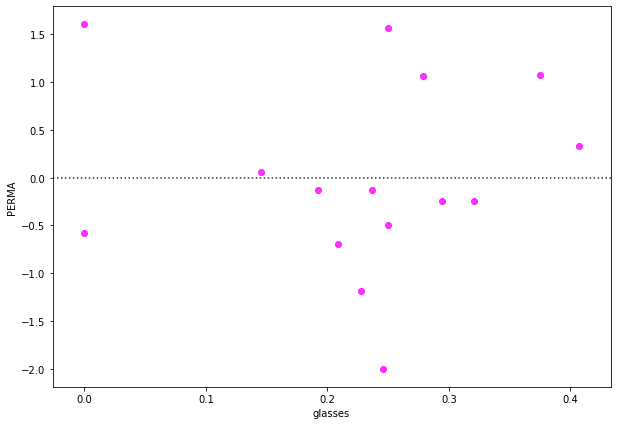

In [24]:
fig = plt.figure(figsize=(10,7))
sns.residplot(X_test_flex.glasses, y_test_flex.PERMA, color='magenta')

Plot a scatter plot using the **glasses** feature and the **PERMA** scores from the test -and predicted dataset.

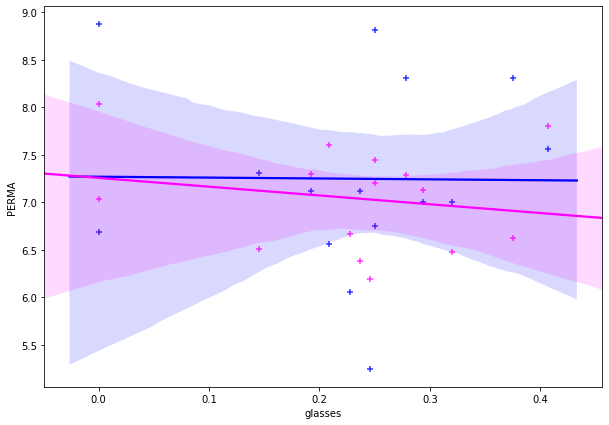

In [25]:
fig = plt.figure(figsize=(10,7))
ax1 = sns.regplot(x=X_test_flex.glasses,y=y_test_flex.PERMA,color='blue', marker='+')
sns.regplot(x=X_test_flex.glasses,y=y_pred,color='magenta', marker='+', ax=ax1)

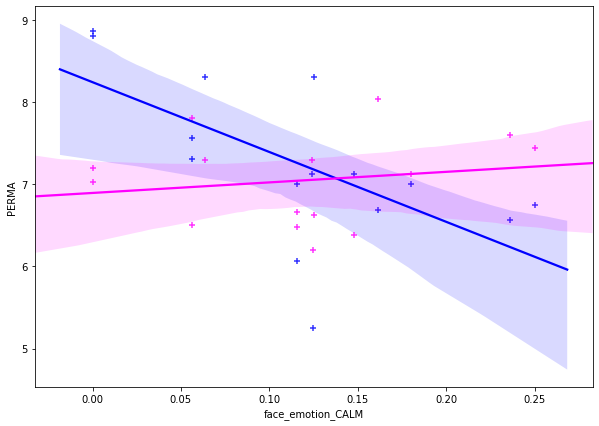

In [26]:
# try to do the same for the CALM emotion
fig = plt.figure(figsize=(10,7))
ax1 = sns.regplot(x=X_test_flex.face_emotion_CALM,y=y_test_flex.PERMA,color='blue', marker='+')
sns.regplot(x=X_test_flex.face_emotion_CALM,y=y_pred,color='magenta', marker='+', ax=ax1)

['data_memorability', 'face_emotion_CALM', 'face_emotion_CONFUSED', 'face_emotion_SURPRISED', 'male', 'emotion_label_acceptance', 'emotion_label_rage', 'emotion_label_sadness', 'emotion_label_serenity', 'emotion_label_terror']


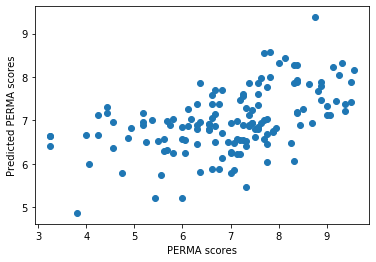

In [27]:
print(best_feat)
plt.scatter(target_df.PERMA, reg_best.predict(features_df[best_feat]))
plt.xlabel('PERMA scores')
plt.ylabel('Predicted PERMA scores')
plt.show()